In [1]:
# Imports et chargement des données
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Input, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Définir les graines aléatoires pour la reproductibilité
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
data = pd.read_csv('stock/AAPL.csv', index_col='Date', parse_dates=True)['Close']


data



Date
2013-01-02     16.669012
2013-01-03     16.458618
2013-01-04     16.000164
2013-01-07     15.906051
2013-01-08     15.948846
                 ...    
2022-12-23    130.344498
2022-12-27    128.535492
2022-12-28    124.591385
2022-12-29    128.120331
2022-12-30    128.436661
Name: Close, Length: 2518, dtype: float64

In [2]:
# Prétraitement des données


# Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

# Sauvegarder le scaler pour une utilisation future
joblib.dump(scaler, 'scaler_minmax_gru.pkl')

['scaler_minmax_gru.pkl']

In [3]:
#  Création des séquences
# Fonction pour créer les séquences

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 4
X, y = create_sequences(prices_scaled, sequence_length)

# Diviser les données en ensembles d'entraînement et de test (70% / 30%)
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Forme de X_train: {X_train.shape}")
print(f"Forme de y_train: {y_train.shape}")
print(f"Forme de X_test: {X_test.shape}")
print(f"Forme de y_test: {y_test.shape}")

Forme de X_train: (1760, 3, 1)
Forme de y_train: (1760, 1)
Forme de X_test: (755, 3, 1)
Forme de y_test: (755, 1)


In [4]:
#  Définition du modèle

def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(GRU(units=64, activation='tanh', return_sequences=True)),
        Dropout(0.25),
        Bidirectional(GRU(units=256, activation='tanh', return_sequences=False)),
        Dropout(0.25),
        Dense(units=1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='huber', metrics=['mae'])
    return model

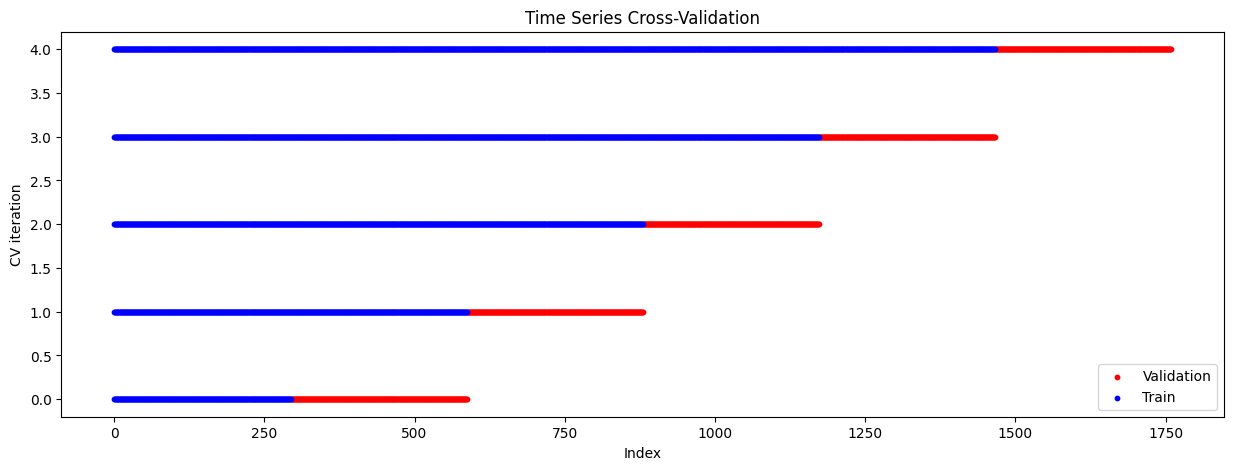

Fold 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Fold 1 validation metrics:
  Loss: 0.0000
  MSE: 0.2319
  MAE: 0.3806
  R²: 0.9836
  SMAPE: 1.63%


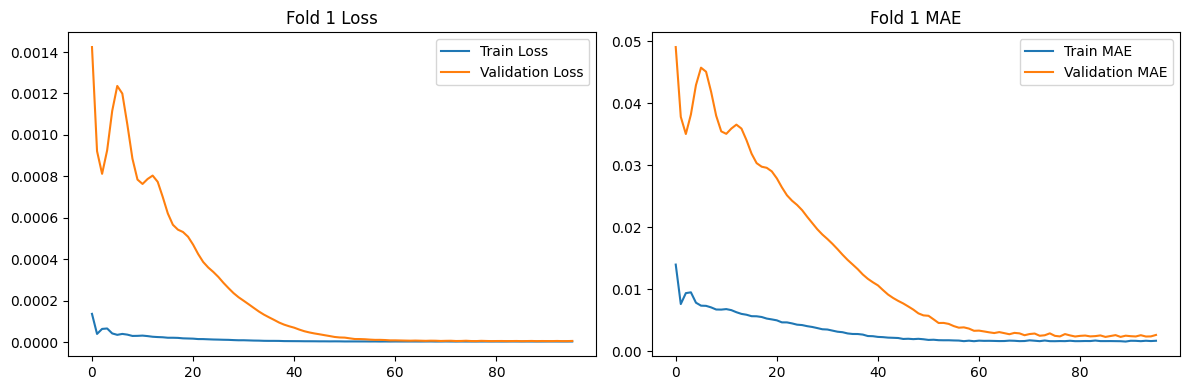

Fold 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Fold 2 validation metrics:
  Loss: 0.0000
  MSE: 0.2642
  MAE: 0.3821
  R²: 0.9572
  SMAPE: 1.55%


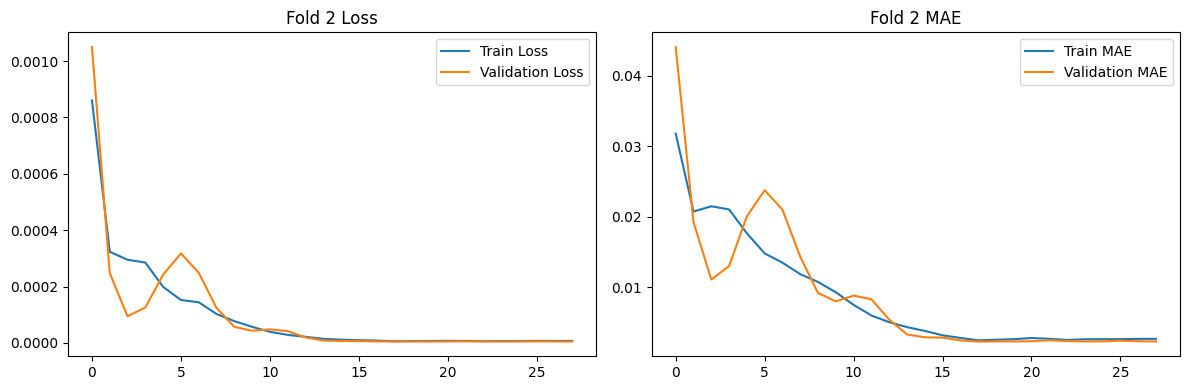

Fold 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Fold 3 validation metrics:
  Loss: 0.0000
  MSE: 0.1821
  MAE: 0.3015
  R²: 0.9915
  SMAPE: 1.02%


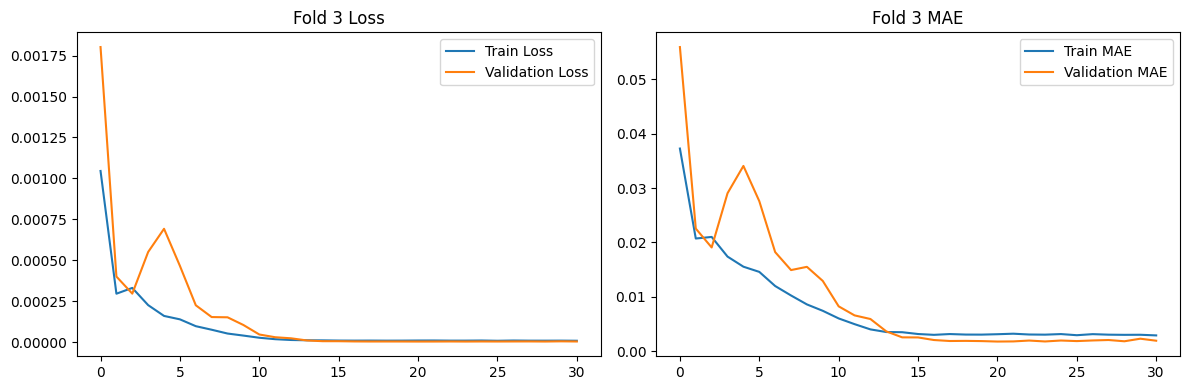

Fold 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
Fold 4 validation metrics:
  Loss: 0.0000
  MSE: 0.6124
  MAE: 0.5733
  R²: 0.9778
  SMAPE: 1.32%


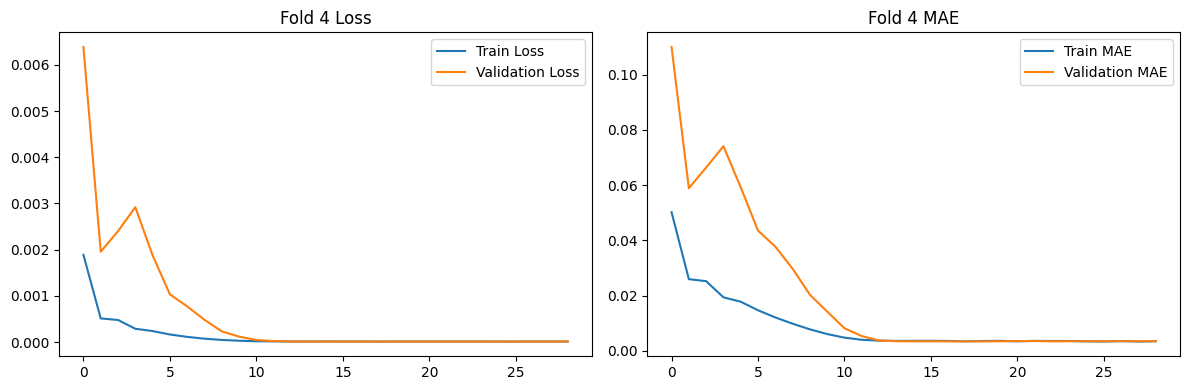

Fold 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step
Fold 5 validation metrics:
  Loss: 0.0000
  MSE: 1.1108
  MAE: 0.7945
  R²: 0.9849
  SMAPE: 1.67%


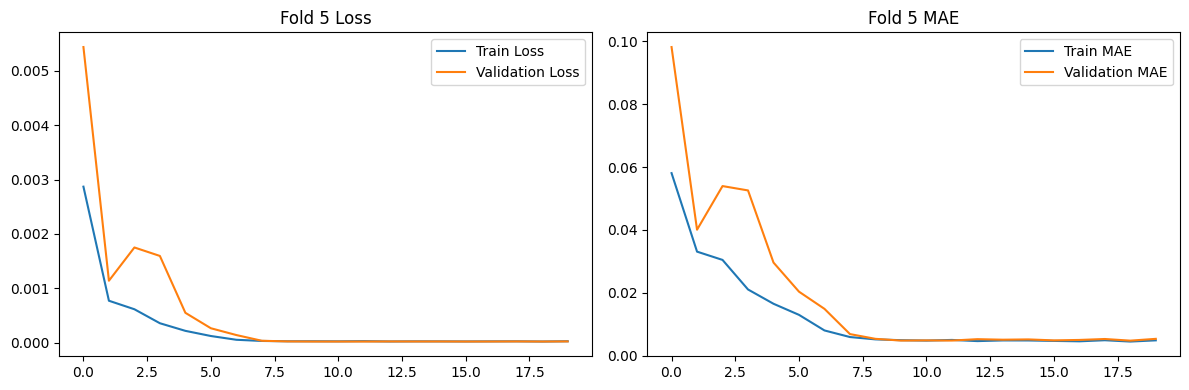


Résultats de la validation croisée temporelle:
Loss: 0.0000 ± 0.0000
MSE: 0.4803 ± 0.3499
MAE: 0.4864 ± 0.1782
R²: 0.9790 ± 0.0117
SMAPE: 1.44% ± 0.24%


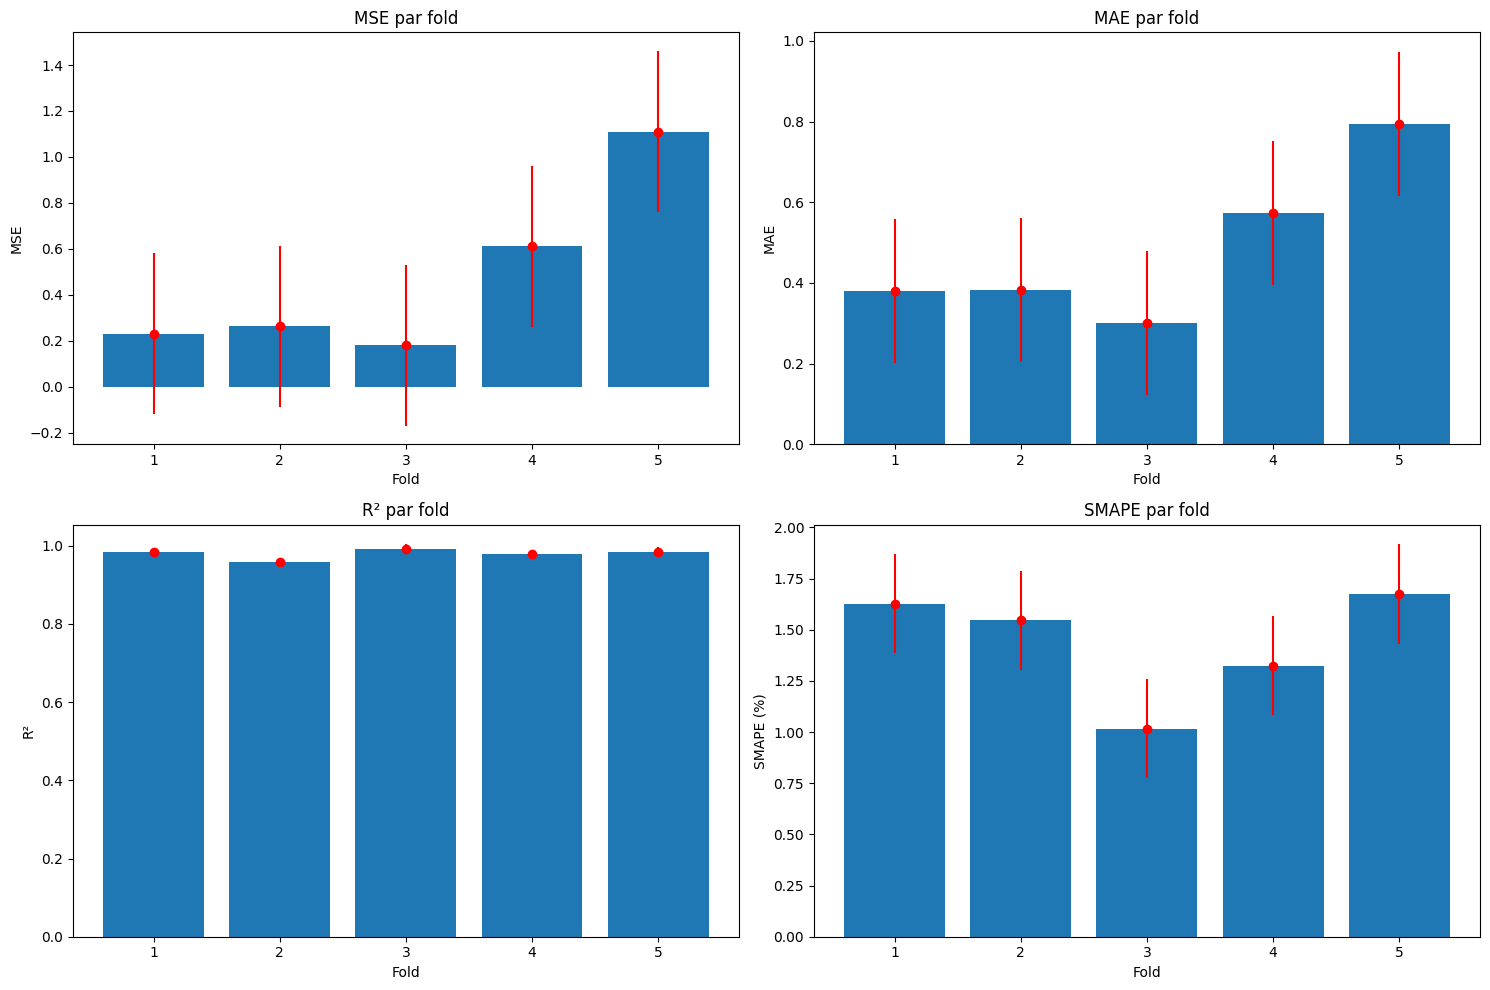

In [5]:
# Validation croisée temporelle
# Définir la validation croisée temporelle
set_seed(42)
tscv = TimeSeriesSplit(n_splits=5)

# Initialiser les listes pour stocker les métriques
val_losses = []
val_maes = []
val_mses = []
val_r2s = []
val_smapes = []

# Fonction pour calculer le SMAPE (Symmetric Mean Absolute Percentage Error)
def calculate_smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Visualiser les splits de validation croisée
plt.figure(figsize=(15, 5))
for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    plt.scatter(val_idx, [i] * len(val_idx), c='red', s=10, label='Validation' if i == 0 else "")
    plt.scatter(train_idx, [i] * len(train_idx), c='blue', s=10, label='Train' if i == 0 else "")

plt.legend()
plt.title('Time Series Cross-Validation')
plt.xlabel('Index')
plt.ylabel('CV iteration')
plt.show()

# Boucle de validation croisée temporelle
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold+1}/{tscv.n_splits}")
    
    # Créer les ensembles d'entraînement et de validation pour cette itération
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Créer et compiler le modèle
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    # Définir early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Entraîner le modèle
    history = model.fit(
        X_train_fold, y_train_fold,
        batch_size=128,
        epochs=100,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Faire des prédictions sur l'ensemble de validation
    y_val_pred = model.predict(X_val_fold)
    
    # Convertir les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_true_unscaled = scaler.inverse_transform(y_val_fold.reshape(-1, 1))
    y_val_pred_unscaled = scaler.inverse_transform(y_val_pred)
    
    # Calculer les métriques
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    mse = mean_squared_error(y_val_true_unscaled, y_val_pred_unscaled)
    mae = mean_absolute_error(y_val_true_unscaled, y_val_pred_unscaled)
    r2 = r2_score(y_val_true_unscaled, y_val_pred_unscaled)
    smape = calculate_smape(y_val_true_unscaled, y_val_pred_unscaled)
    
    # Stocker les métriques
    val_losses.append(model.evaluate(X_val_fold, y_val_fold, verbose=0)[0])
    val_maes.append(mae)
    val_mses.append(mse)
    val_r2s.append(r2)
    val_smapes.append(smape)
    
    print(f"Fold {fold+1} validation metrics:")
    print(f"  Loss: {val_losses[-1]:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  SMAPE: {smape:.2f}%")
    
    # Tracer les courbes d'apprentissage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold+1} Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'Fold {fold+1} MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Calculer les moyennes et écarts-types des métriques
mean_loss = np.mean(val_losses)
std_loss = np.std(val_losses)

mean_mae = np.mean(val_maes)
std_mae = np.std(val_maes)

mean_mse = np.mean(val_mses)
std_mse = np.std(val_mses)

mean_r2 = np.mean(val_r2s)
std_r2 = np.std(val_r2s)

mean_smape = np.mean(val_smapes)
std_smape = np.std(val_smapes)

# Afficher les performances moyennes de la validation croisée avec écarts-types
print("\nRésultats de la validation croisée temporelle:")
print(f"Loss: {mean_loss:.4f} ± {std_loss:.4f}")
print(f"MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"MAE: {mean_mae:.4f} ± {std_mae:.4f}")
print(f"R²: {mean_r2:.4f} ± {std_r2:.4f}")
print(f"SMAPE: {mean_smape:.2f}% ± {std_smape:.2f}%")

# Visualiser les métriques par fold
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.bar(range(1, tscv.n_splits + 1), val_mses)
plt.errorbar(range(1, tscv.n_splits + 1), val_mses, yerr=std_mse, fmt='o', color='r')
plt.title('MSE par fold')
plt.xlabel('Fold')
plt.ylabel('MSE')

plt.subplot(2, 2, 2)
plt.bar(range(1, tscv.n_splits + 1), val_maes)
plt.errorbar(range(1, tscv.n_splits + 1), val_maes, yerr=std_mae, fmt='o', color='r')
plt.title('MAE par fold')
plt.xlabel('Fold')
plt.ylabel('MAE')

plt.subplot(2, 2, 3)
plt.bar(range(1, tscv.n_splits + 1), val_r2s)
plt.errorbar(range(1, tscv.n_splits + 1), val_r2s, yerr=std_r2, fmt='o', color='r')
plt.title('R² par fold')
plt.xlabel('Fold')
plt.ylabel('R²')

plt.subplot(2, 2, 4)
plt.bar(range(1, tscv.n_splits + 1), val_smapes)
plt.errorbar(range(1, tscv.n_splits + 1), val_smapes, yerr=std_smape, fmt='o', color='r')
plt.title('SMAPE par fold')
plt.xlabel('Fold')
plt.ylabel('SMAPE (%)')

plt.tight_layout()
plt.show()

In [6]:
#  Entraînement du modèle final
# Créer et compiler le modèle final
set_seed(42)
final_model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))

# Définir early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraîner le modèle sur l'ensemble complet des données d'entraînement
final_history = final_model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=100,
    verbose=1
)



Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0060 - mae: 0.0865
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 9.7045e-04 - mae: 0.0369
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.8444e-04 - mae: 0.0339
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.1222e-04 - mae: 0.0233
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.1201e-04 - mae: 0.0171
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.0101e-04 - mae: 0.0117
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.1336e-05 - mae: 0.0075
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.5294e-05 - mae: 0.0059
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.3387e-05 - mae: 0.0056
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.3705e-05 - mae: 0.0056
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.8567e-05 - mae: 0.0059
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.2999

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4397e-04 - mae: 0.0124 
Test Loss: 0.0002, Test MAE: 0.0148
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


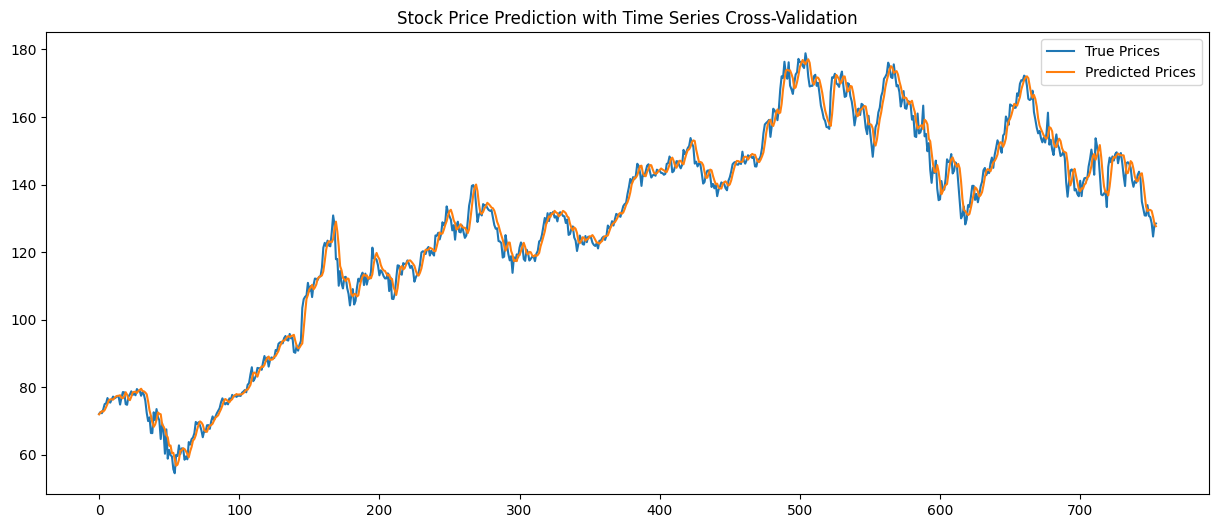

In [7]:
# Évaluation du modèle final
# Évaluer le modèle sur l'ensemble de test
test_loss, test_mae = final_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Faire des prédictions
y_pred = final_model.predict(X_test)

# Convertir les prix prédits et réels à l'échelle initiale
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = scaler.inverse_transform(y_pred)

# Tracer les résultats
plt.figure(figsize=(15, 6))
plt.plot(y_test_unscaled, label='True Prices')
plt.plot(y_pred_unscaled, label='Predicted Prices')
plt.title('Stock Price Prediction with Time Series Cross-Validation')
plt.legend()
plt.show()

In [8]:
# Métriques d'évaluation détaillées
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_directional_accuracy(y_true, y_pred):
    # Calcul des différences entre les points consécutifs
    y_true_direction = np.diff(y_true.flatten())
    y_pred_direction = np.diff(y_pred.flatten())
    
    # Calcul de la précision directionnelle
    correct_direction = np.sum((y_true_direction * y_pred_direction) > 0)
    return (correct_direction / len(y_true_direction)) * 100

# Calculer les métriques
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
mape = calculate_mape(y_test_unscaled, y_pred_unscaled)
da = calculate_directional_accuracy(y_test_unscaled, y_pred_unscaled)

# Afficher les métriques
print("Métriques d'évaluation:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Directional Accuracy: {da:.2f}%")

Métriques d'évaluation:
MSE: 10.6627
RMSE: 3.2654
MAE: 2.4731
R²: 0.9885
MAPE: 1.98%
Directional Accuracy: 47.08%


In [9]:
#Sauvegarder le modèle final
final_model.save('model_bigru.keras')
print("Modèle sauvegardé avec succès!")

Modèle sauvegardé avec succès!
